In [1]:
# import modules
import sys, os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rcdefaults
from matplotlib.ticker import MultipleLocator
import numpy as np

# Define the relative path to the hamageolib package
root_path = os.path.join(Path().resolve().parent.parent.parent)
package_path = os.path.join(root_path, "hamageolib")

if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))

# import local modules
from hamageolib.research.haoyuan_2d_subduction.legacy_tools import SlabTemperature
import hamageolib.utils.plot_helper as plot_helper

# unit converting
year = 365 * 24 * 3600.0 # year to second
cm_per_yr = 0.01 / year # cm/year to m/s

# Apply offsets to slab surface to get mantle wedge profiles

## Run test case with profile offsets

Below we run a test and plot the results

In [2]:
apply_case_offset = False

if apply_case_offset:

    case_path = os.path.join(root_path, "big_tests", "TwoDSubduction", 'EBA_CDPT_test_perplex_mixing_log')

    from hamageolib.utils.file_reader import read_aspect_header_file

    # Check if the folder exists and contains test files
    if not os.path.exists(case_path) or not os.listdir(case_path):
        raise FileExistsError("Skipping test: big test contents not found in 'big_tests/'.")

    # Make output directory and clear old files
    o_dir = os.path.join(root_path, "dtemp", "TwoDSubduction_vtk_pp")
    if not os.path.isdir(o_dir):
        os.mkdir(o_dir)
    o_file = os.path.join(o_dir, "slab_temperature_00104.txt")
    if os.path.isfile(o_file):
        os.remove(o_file)

    vtu_snapshot = 104 # 0 Ma
    _, _, _ = SlabTemperature(case_path, vtu_snapshot, o_file, output_slab=True, fix_shallow=True, offsets=[-5e3, -10e3])
    assert(os.path.isfile(o_file))  # assert the outputs of temperature profiles

    pd_data = read_aspect_header_file(o_file)

Figure on the left shows the points on different profiles. Here we apply offset of 5 km, 10 km, respectively to the slab surface. Figure on the right is the related T profiles

In [3]:
if apply_case_offset:

    fig = plt.figure(figsize=(5*2, 5))
    gs = gridspec.GridSpec(1, 2)

    # create mask for offset data
    mask_mh = (pd_data['x bot']**2.0 + pd_data['y bot']**2.0 < 6371e3**2.0)
    mask0 = (pd_data['x offset 0']**2.0 + pd_data['y offset 0']**2.0 < 6371e3**2.0)
    mask1 = (pd_data['x offset 1']**2.0 + pd_data['y offset 1']**2.0 < 6371e3**2.0)

    # 1: plot the coordinates
    ax = fig.add_subplot(gs[0, 0])

    ax.plot(pd_data['x']/1e3, pd_data['y']/1e3, label="surface")
    ax.plot(pd_data['x bot'][mask_mh]/1e3, pd_data['y bot'][mask_mh]/1e3, label="moho")
    ax.plot(pd_data['x offset 0'][mask0]/1e3, pd_data['y offset 0'][mask0]/1e3, label="offset 0")
    ax.plot(pd_data['x offset 1'][mask1]/1e3, pd_data['y offset 1'][mask1]/1e3, label="offset 1")

    ax.set_xlim([4000.0, 5500.0])
    ax.set_ylim([3500.0, 3800.0])

    ax.set_xlabel("X (km)")
    ax.set_ylabel("Y (km)")
    ax.legend()

    # 1: plot the temperatures
    ax = fig.add_subplot(gs[0, 1])

    ax.plot(pd_data["Ttop"], pd_data["depth"]/1e3)
    ax.plot(pd_data["Tbot"], pd_data["depth"]/1e3)
    ax.plot(pd_data["Toffset 0"], pd_data["depth"]/1e3)
    ax.plot(pd_data["Toffset 1"], pd_data["depth"]/1e3)

    ax.set_xlim([0, 2000])
    ax.set_ylim([0, 150])

    ax.invert_yaxis()

    ax.set_xlabel("T (K)")
    ax.set_ylabel("Depth (km)")

    ax.grid()

# Analytical solution from England & Wilkins, 2004

## First, we create an instance of the corner flow model.

In [4]:
solve_England_Wilkins_2004 = True

if solve_England_Wilkins_2004:

    from hamageolib.core.AnalyticalSolution import VISCOUS_CORNER_FLOW

    theta_d = np.pi / 4.0 # dipping angle
    mu = 1e21 # mantle viscosity
    U0 =  1 * cm_per_yr # convergence rate

    # make directory to save results
    result_p_dir = os.path.join(root_path, "dtemp")
    if not os.path.isdir(result_p_dir):
        os.mkdir(result_p_dir)
    result_dir = os.path.join(result_p_dir, "England_Wilkins_2004")
    if not os.path.isdir(result_dir):
        os.mkdir(result_dir)

    # coordinate values
    x = np.linspace(-1000e3, 1000e3, 200)
    y = np.linspace(0, 1000e3, 150)
    xx, yy = np.meshgrid(x, y)

    # initiate arrays to save values
    uu = np.zeros(xx.shape)
    vv = np.zeros(xx.shape)
    PP = np.zeros(xx.shape)

    # solve the problem
    VCF = VISCOUS_CORNER_FLOW()
    VCF.PrescribeDipVelocity(theta_d, U0)
    VCF.PrescribeDomainViscosity(mu)
    VCF.SolveArcCorner()
    VCF.SolveOceanicCorner()

    # mesh the solution
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            u, v, _ = VCF.GetFlowVelocity(xx[i, j], yy[i, j])
            P, _ = VCF.GetPressure(xx[i, j], yy[i, j])
            uu[i, j] = u
            vv[i, j] = v
            PP[i, j] = P
    vv_mag = (uu**2.0 + vv**2.0) ** 0.5

Plot the Results

Saved figure: /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/England_Wilkins_2004/solution_layout.pdf


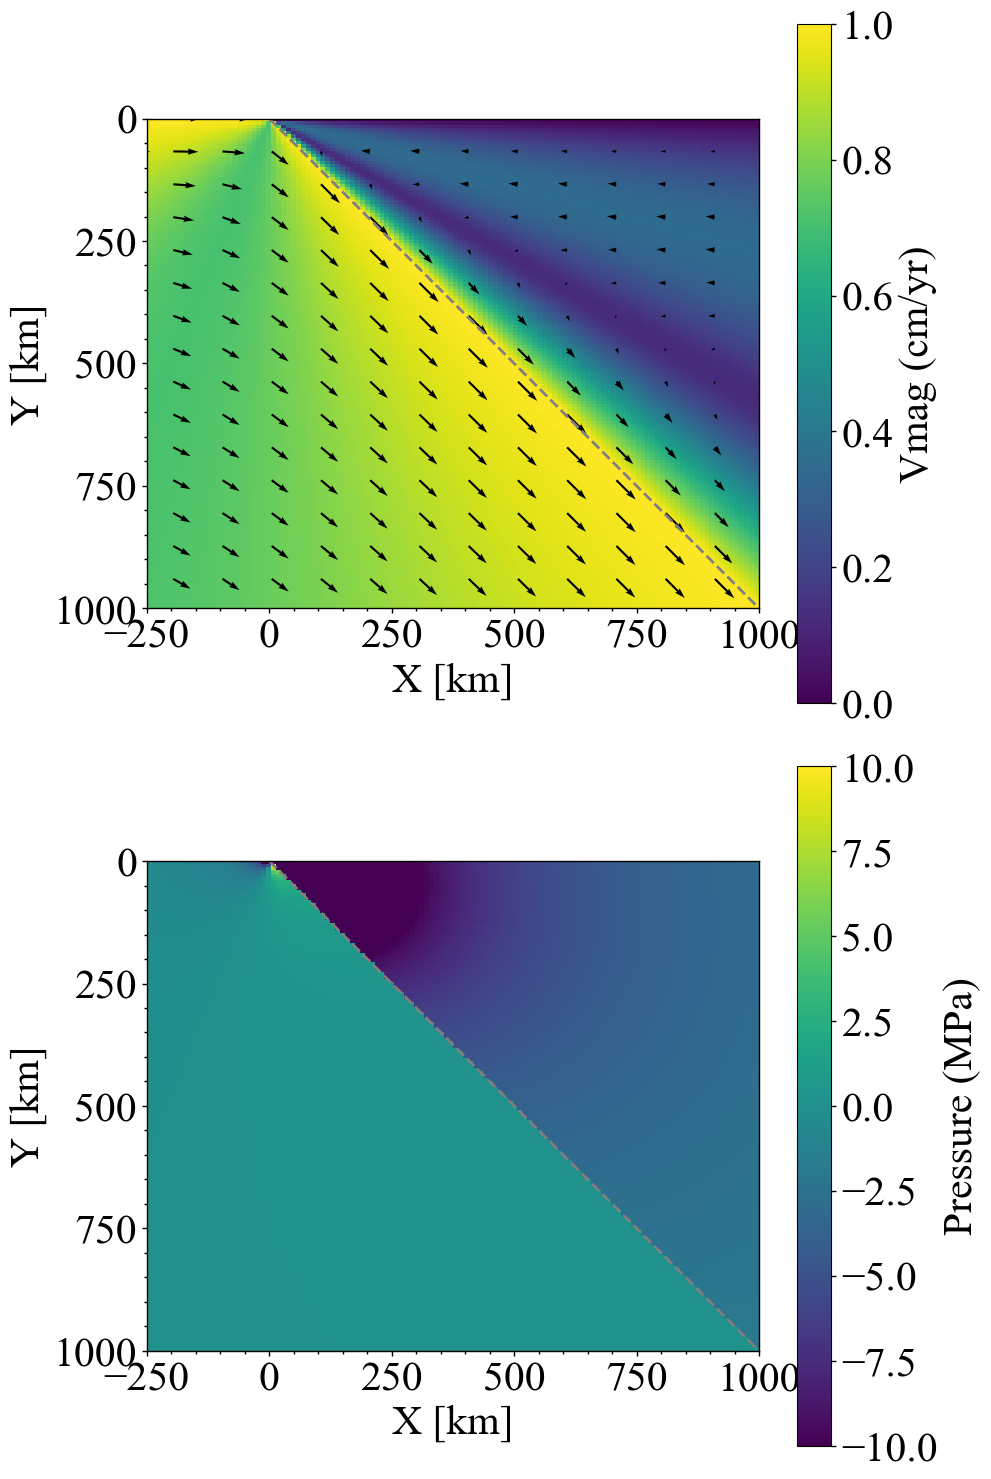

In [5]:
if solve_England_Wilkins_2004:

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 3.0 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (-250.0, 1000.0)
    x_tick_interval = 250.0   # tick interval along x
    y_lim = (0.0, 1000.0)
    y_tick_interval = 250.0  # tick interval along y
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    surface_xs = np.linspace(0, np.linalg.norm(xx, np.inf), 100)
    surface_ys = surface_xs * np.tan(theta_d)
    # Plot the solution
    fig = plt.figure(tight_layout=True, figsize=(10, 15))
    gs = gridspec.GridSpec(2, 1)

    # velocity magnitude and velocity direction
    ax = fig.add_subplot(gs[0, 0])  
    h = ax.pcolormesh(xx/1e3, yy/1e3, vv_mag / cm_per_yr)
    skip = (slice(None, None, 10), slice(None, None, 10))   # resample the quiver, add in a stride
    ax.quiver(xx[skip]/1e3, yy[skip]/1e3, uu[skip]/cm_per_yr, vv[skip]/cm_per_yr, angles='xy')

    ax.plot(surface_xs, surface_ys, color="tab:gray", linestyle="--")  # plot the slab surface

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')

    ax.set_xlabel('X [km]')
    ax.set_ylabel('Y [km]')
    fig.colorbar(h, ax=ax, label='Vmag (cm/yr)')

    # pressure
    ax1 = fig.add_subplot(gs[1, 0])  
    h = ax1.pcolormesh(xx/1e3, yy/1e3, PP/1e6, vmin=-10, vmax=10)
    ax1.plot(surface_xs, surface_ys, color="tab:gray", linestyle="--")  # plot the slab surface

    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim)

    ax1.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax1.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax1.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax1.invert_yaxis()
    ax1.set_aspect('equal', adjustable='box')

    ax1.set_xlabel('X [km]')
    ax1.set_ylabel('Y [km]')
    fig.colorbar(h, ax=ax1, label='Pressure (MPa)')

    # Adjust spine thickness for this plot
    for spine in ax.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)
    for spine in ax1.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # Reset rcParams to defaults
    fig_path = os.path.join(result_dir, "solution_layout.pdf")
    fig.savefig(fig_path)
    print("Saved figure: %s" % fig_path)

    rcdefaults()

## Next, we solve the analytic solution and reproduce Fig.5

In [6]:
if solve_England_Wilkins_2004:

    from hamageolib.core.AnalyticalSolution import WK2004
    
    constants = WK2004.Constants(
        age=100.0e6*year,            # s
        U=0.1/year,                # m/s
        theta_d=np.pi/6.0, # radians
        a=100e3,               # meters
        zw=60e3,
        Ta=1280.0 + 273.15,             # Kelvin
        Tsf=273.15,
        kappa=8e-7,
        rho=3300.0,
        cp=1e3, # J Kg^-1 K^-1
        plate_T_model=0
    )

    WK_model = WK2004(constants)

Test computation at a certain depth

Note here, we can set to use_top_thickness. This will compute the top thickness shallower than zw from the diffusive thickness.

In [7]:
WK_model.a = 100e3
# WK_model.a = 100e3
print(WK_model.ss_temperature(90e3, use_top_thickness=True, debug=True))

alpha =  9310.12060023984
T1 = 1118.115573896842, self.Tsf = 273.15, erf_multiplier = 105.6112583058552, erf_factor = 7.419684777268893, denominator = 2.224378508687761, erf(erf_factor) = 1.0, Ts = 700.4949093713263
700.4949093713263


/home/lochy/ASPECT_PROJECT/HaMaGeoLib/hamageolib/core/AnalyticalSolution.py:496: RuntimeWarning: divide by zero encountered in true_divide
  erf_factor = self.a / (2 * self.diffusive_thickness(depth))
/home/lochy/ASPECT_PROJECT/HaMaGeoLib/hamageolib/core/AnalyticalSolution.py:497: RuntimeWarning: invalid value encountered in true_divide
  denominator = (1 + np.pi**0.5 * alpha / (2.0 * self.diffusive_thickness(depth)))
/home/lochy/ASPECT_PROJECT/HaMaGeoLib/hamageolib/core/AnalyticalSolution.py:496: RuntimeWarning: divide by zero encountered in true_divide
  erf_factor = self.a / (2 * self.diffusive_thickness(depth))
/home/lochy/ASPECT_PROJECT/HaMaGeoLib/hamageolib/core/AnalyticalSolution.py:497: RuntimeWarning: invalid value encountered in true_divide
  denominator = (1 + np.pi**0.5 * alpha / (2.0 * self.diffusive_thickness(depth)))
/home/lochy/ASPECT_PROJECT/HaMaGeoLib/hamageolib/core/AnalyticalSolution.py:496: RuntimeWarning: divide by zero encountered in true_divide
  erf_factor = se

saved figure: /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/England_Wilkins_2004/EW_2005_fig5_1


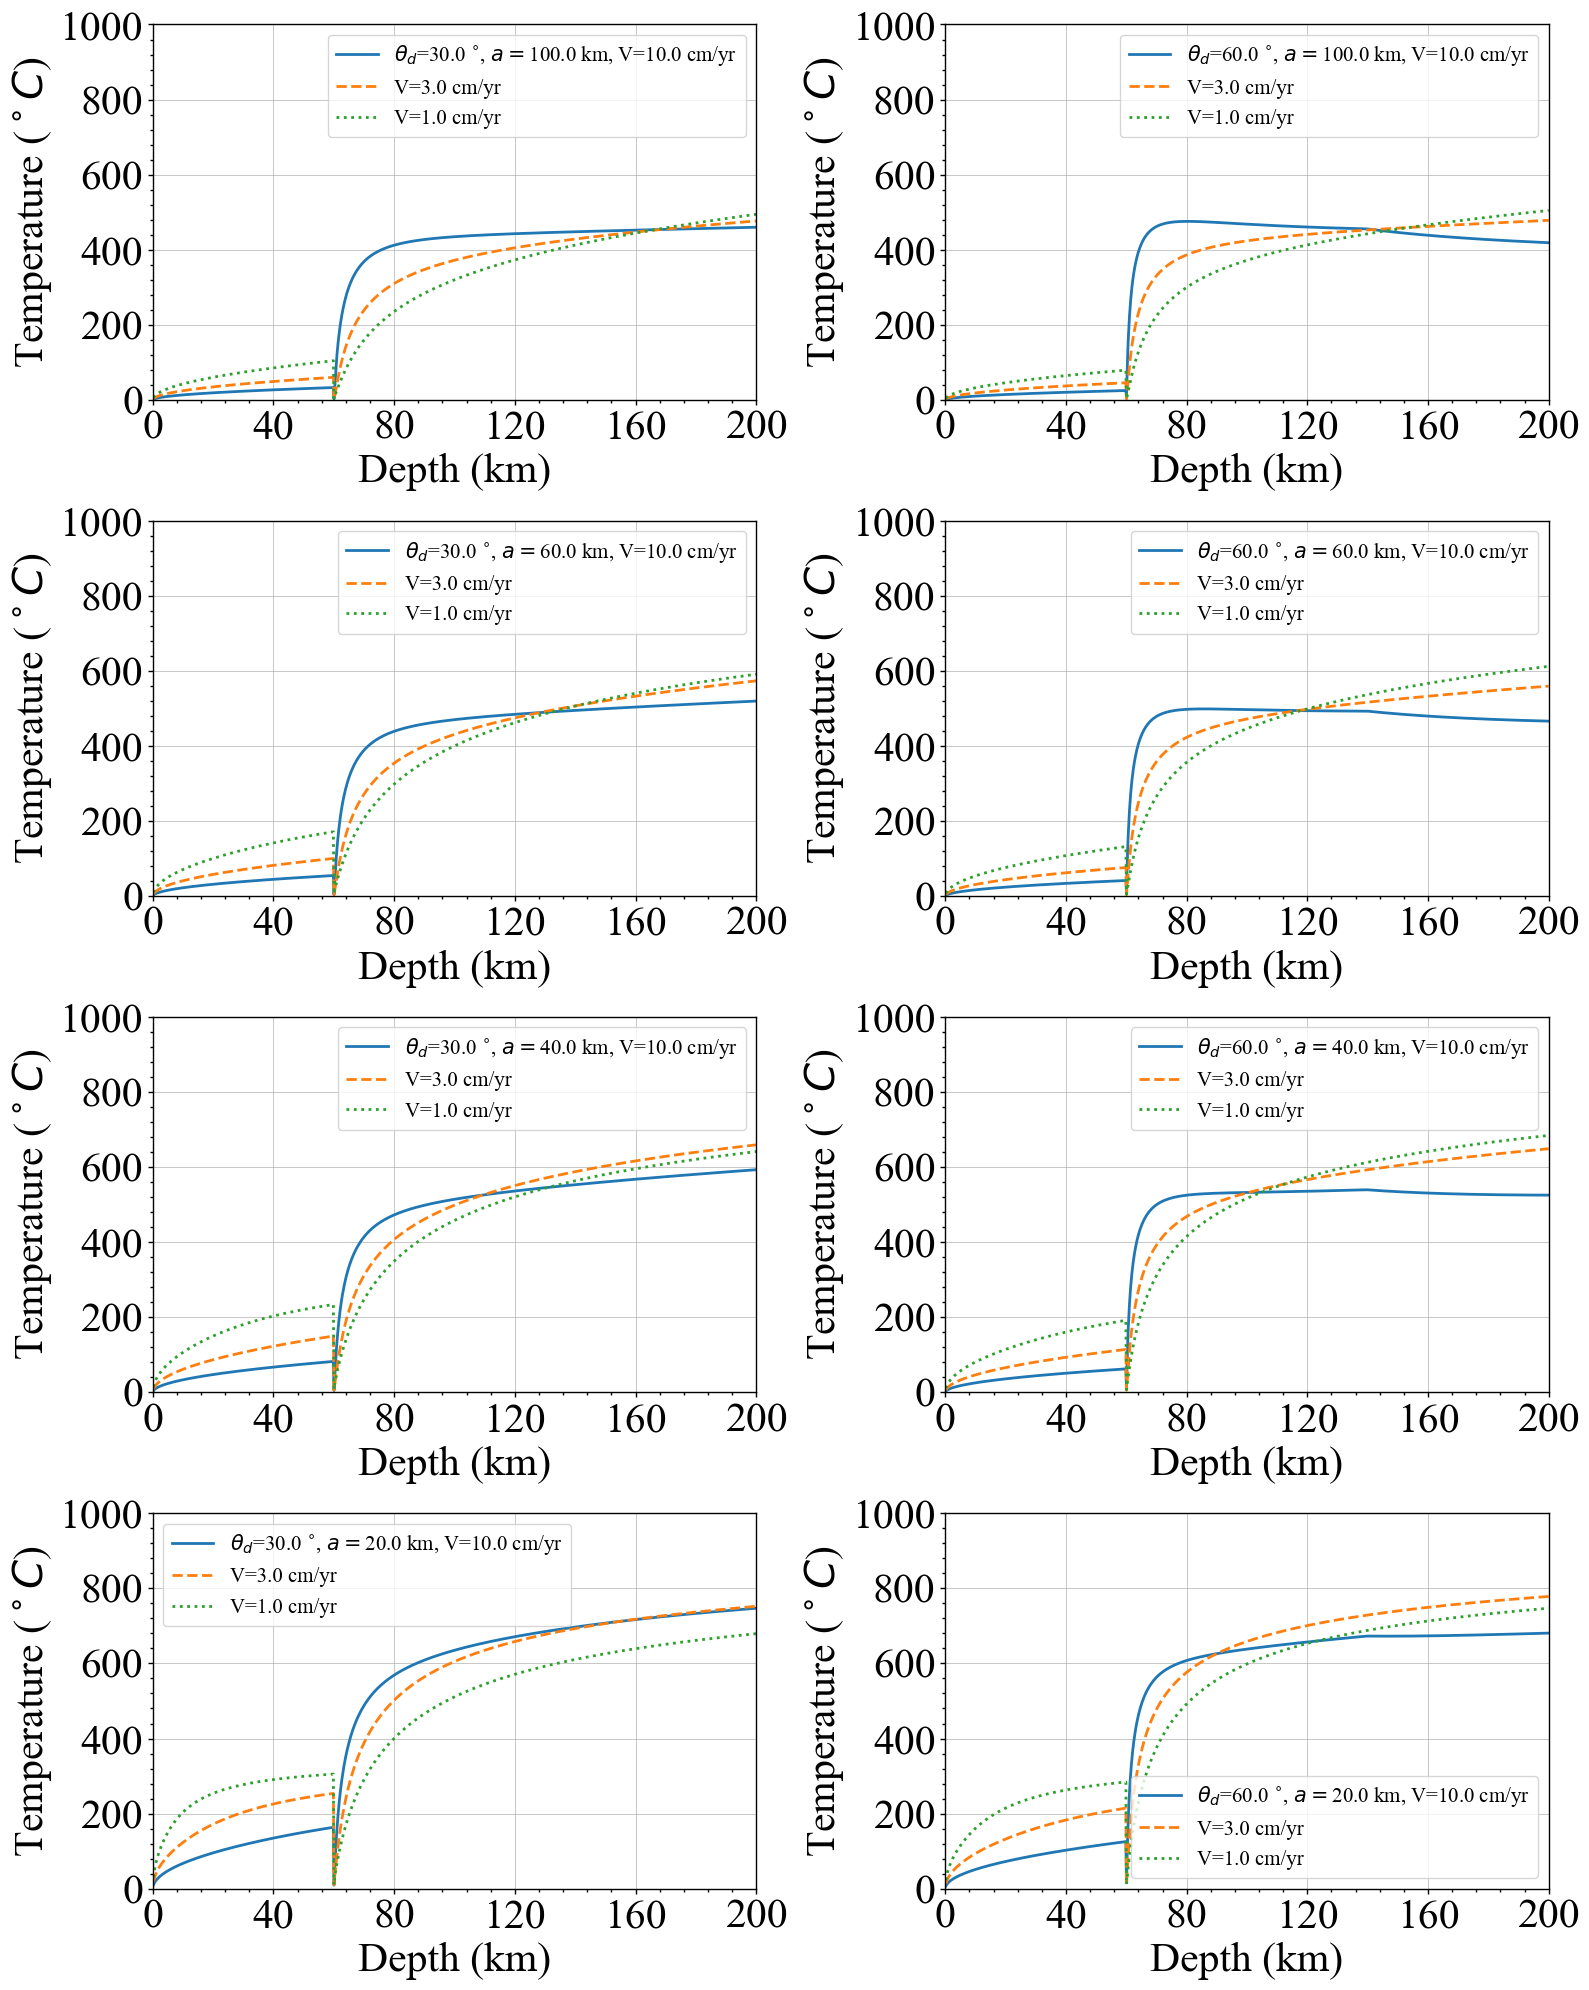

In [ ]:
if solve_England_Wilkins_2004:

    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 3.0 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (0.0, 200.0)
    x_tick_interval = 40.0   # tick interval along x
    y_lim = (0.0, 1000.0)
    y_tick_interval = 200.0  # tick interval along y
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })


    # assign overriding plate thickness
    zw = 60e3
    use_top_thickness=True
    WK_model.zw = zw

    # assign depths
    depths = np.linspace(0, 200e3, 1000)
    # mask = (depths > zw)  # use this option when using the advective thickness
    mask = np.full(depths.shape, 1, dtype=bool)  # use this option when using the top thickness

    # create grid of theta_d and a
    theta_d_array = [np.pi/6.0, np.pi/3.0]
    a_array = [100e3, 60e3, 40e3, 20e3]
    U_array = [0.1/year, 0.03/year, 0.01/year]

    # create figure 
    fig = plt.figure(figsize=(8*len(theta_d_array), 5*len(a_array)), tight_layout=True)
    gs = gridspec.GridSpec(len(a_array), len(theta_d_array))

    for i_theta, theta_d in enumerate(theta_d_array):
        for j_a, a in enumerate(a_array):
            # add axis to plot 
            ax = fig.add_subplot(gs[j_a, i_theta])

            # set theta_d and a in model
            WK_model.theta_d = theta_d
            WK_model.a = a

            for k_U, U in enumerate(U_array):

                # set U in model
                WK_model.U = U

                # compute slab surface temperature
                Ts = np.full(depths.shape, WK_model.Tsf)
                Ts[mask] = WK_model.ss_temperature(depths[mask], use_top_thickness=use_top_thickness)


                # plot Ts vs depths
                if k_U == 0:
                    _label = r"$\theta_d$="+str(np.round(np.degrees(theta_d)))+r" $^{\circ}$, $a=$"+str(a/1e3) + " km, " +\
                            "V=" + str(np.round(U*year*100.0)) + " cm/yr"
                    _linestyle = "-"
                elif k_U == 1:
                    _label = "V=" + str(np.round(U*year*100.0)) + " cm/yr"
                    _linestyle = "--"
                elif k_U == 2:
                    _label = "V=" + str(np.round(U*year*100.0)) + " cm/yr"
                    _linestyle = "dotted"
                ax.plot(depths/1e3, Ts-273.15, label=_label, linestyle=_linestyle)
                

            ax.set_xlim(x_lim)
            ax.set_ylim(y_lim)

            ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
            ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
            ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
            ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

            ax.set_xlabel("Depth (km)")
            ax.set_ylabel(r"Temperature ($^\circ C$)")

            ax.legend()

            ax.grid()

            # Adjust spine thickness for this plot
            for spine in ax.spines.values():
                spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


    fig_path = os.path.join(result_dir, "EW_2005_fig5_%d.png" % use_top_thickness)

    fig.savefig(fig_path)

    print("saved figure: %s" % fig_path)

    # Reset rcParams to defaults

    rcdefaults()